# 实践：CNN模型编程教学

## 1 卷积神经网络及其关键组件

神经网络可以使用 `torch.nn` 包进行创建。

`nn.Module` 包含网络中的各种层和一个返回输出的 `forward(input)` 方法。

例如，请看这个对数字图像进行分类的网络LeNet：

<img src="./assets/lenet.png" style="zoom:100%;" />

这是一个简单的 feed-forward network。它接收输入信息，将其逐层馈送，最后给出输出结果。

神经网络的典型训练过程如下：

- 定义神经网络，其中包含一些可学习的 parameters（或weights）

- 在数据集上进行迭代

- 通过网络处理 input

- 计算loss（输出离正确还有多远）

- 将梯度传回网络参数中

- 更新网络权重，通常使用简单的更新规则：`weight = weight - learning_rate * gradient`

### 1.1 网络结构的定义

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [64]:
class Net(nn.Module):
    """定义 LeNet 的网络结构"""

    def __init__(self):
        super(Net, self).__init__()  # 调用父类的 __init__() 方法
        # 卷积层 conv
        # conv1: 输入大小为32*32，输出大小为28*28，输入通道为1，输出为6，卷积核大小为5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # conv2: 输入大小为14*14，输出大小为10*10，输入通道为6，输出为16，卷积核大小为5
        self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        """ ------------- end -------------- """
        # 全连接层 fc
        # fc1: 输入神经元数目 16 * 5 * 5，输出神经元数目 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        """ -------- Your code here -------- """
        # fc2: 输入神经元数目 120，输出神经元数目 84
        self.fc2 = nn.Linear(120, 84)
        # fc3: 输入神经元数目 84，输出神经元数目 10
        self.fc3 = nn.Linear(84, 10)
        """ ------------- end -------------- """

    def forward(self, x):
        # conv1 - relu - maxpool(2x)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # conv2 - relu -maxpool(2x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        """ ------------- end -------------- """
        # flatten
        x = torch.flatten(x, start_dim=1, end_dim=-1)  # 把除了 batch 维度(dim=0)的数据全部 flatten
        # fc1 - relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [65]:
# 输出网络结构
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


我们只需定义 `forward` 函数，`backward` 函数会使用 `autograd` 自动计算。可以在前向函数中使用任何 tensor 运算。

模型的**可学习参数**由 `net.parameters()` 返回。

In [66]:
net.parameters()

<generator object Module.parameters at 0x0000022F821AFAE0>

`net.parameters()` 是一个 `generator` 对象，可以进行迭代调用。

该 `generator` 中的每一个参数类型都是 `torch.nn.Parameter()`，可以通过 `.data` 和 `.grad` 分别调用参数的数值与梯度(均为 tensor)。

In [67]:
params = list(net.parameters())
print(f"The number of params: {len(params)}")
for i in range(len(params)):
    print(f"param[{i}] 的形状为: {params[i].size()}")  # 打印 param[i] 的形状

The number of params: 10
param[0] 的形状为: torch.Size([6, 1, 5, 5])
param[1] 的形状为: torch.Size([6])
param[2] 的形状为: torch.Size([16, 6, 5, 5])
param[3] 的形状为: torch.Size([16])
param[4] 的形状为: torch.Size([120, 400])
param[5] 的形状为: torch.Size([120])
param[6] 的形状为: torch.Size([84, 120])
param[7] 的形状为: torch.Size([84])
param[8] 的形状为: torch.Size([10, 84])
param[9] 的形状为: torch.Size([10])


注意：上面的 `params[i]`，间隔代表每层的 `weights` 和 `bias`。

让我们试试 `32x32` 的随机输入。注：该网络（LeNet）的预期输入大小为 `32x32`。要在 MNIST 数据集上使用该网络，请将数据集中的图像调整为 `32x32`。

注意，此处并没有使用 `net.forward(input)`, 而是直接使用了 `net(input)` 进行前项传播。这是因为 `Net` 类继承了 `nn.Module` 类中的 `__call__` 方法，定义了表示该实例如何被调用。这些 magic method 是自动调用的，可以理解为父类定义的`__call__` 方法调用了子类定义的 `forward` 函数。

In [68]:
input = torch.randn(1, 1, 32, 32)  # 随机生成一个图片
input.requires_grad = True  # 设置计算 input 的梯度
out = net(input)
print(out)

tensor([[-0.0555,  0.0532,  0.0230,  0.0029,  0.0131,  0.1070, -0.0534, -0.0196,
          0.0735,  0.0084]], grad_fn=<AddmmBackward0>)


将所有参数的梯度缓存清零，并使用随机梯度反推：

In [69]:
net.zero_grad()
out.backward(torch.randn(1, 10))
input.grad

tensor([[[[ 6.7816e-06,  9.7644e-05,  1.7583e-04,  ...,  1.4670e-05,
           -2.2106e-04,  0.0000e+00],
          [-1.9365e-04, -2.7680e-05, -7.5513e-05,  ..., -4.5279e-04,
           -1.9587e-04, -1.9003e-04],
          [ 1.6933e-04,  4.7252e-04,  3.0327e-04,  ...,  8.8993e-05,
           -4.6855e-04,  2.2839e-06],
          ...,
          [ 1.1059e-04, -1.7408e-04,  8.7069e-05,  ...,  3.3004e-04,
           -7.5918e-04, -2.3339e-04],
          [ 0.0000e+00,  0.0000e+00, -4.7500e-04,  ..., -1.7811e-04,
           -1.7659e-04, -6.7463e-05],
          [ 0.0000e+00,  0.0000e+00, -2.7492e-04,  ..., -6.7486e-05,
           -4.6911e-04,  0.0000e+00]]]])

> 注意： `torch.nn` 仅支持 mini-batches。即，整个 `torch.nn` 软件包只支持 mini-batch 样本的输入，而不支持单个样本的输入。例如，`nn.Conv2d` 将接收 `(B, C, H, W)` 的 4D tensor。如果只有单个样本，只需使用 `input.unsqueeze(0)` 添加一个假的 batch 维度即可。

### 3.2 损失函数 

损失函数利用 (`input`, `target`) 这对输入，计算出一个估计 `input` 与 `target` 之间距离的值。

`nn` 软件包中有几种不同的[损失函数](https://pytorch.org/docs/nn.html#loss-functions)。一个简单的损失函数是：`nn.MSELoss`，它计算输出与目标之间的均方误差。

In [70]:
output = net(input)
target = torch.randn(10)  # 生成形状为 (10) 随机数
target = target.view(1, -1)  # 相当于 numpy 的 reshape，改变形状为 (1, 10)
target

tensor([[-0.1361, -2.4984, -0.0997, -0.7141, -1.6717, -0.1548, -2.2071, -0.3988,
         -0.3203,  1.7211]])

In [71]:
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(1.7824, grad_fn=<MseLossBackward0>)


### 3.3 误差反向传播

要反向传播误差，我们只需 `loss.backward()`。不过在此之前，需要清除现有的梯度，否则梯度将累积到现有梯度中。

现在我们调用 `loss.backward()`，看看 `conv1` 的 `bias` 在回传前后的梯度。

In [72]:
net.zero_grad()  # 清空所有参数的 gradient buffer

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0209,  0.0121,  0.0033,  0.0373, -0.0043,  0.0039])


### 更新权重

实际应用中最简单的更新规则是 Stochastic Gradient Descent (SGD, 随机梯度下降)：

`weight = weight - learning_rate * gradient`

我们可以用简单的 Python 代码实现这一功能：

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)  # sub_() 为就地操作相减
```

不过，由于使用的是神经网络，因此需要使用各种不同的更新规则，如 SGD、Nesterov-SGD、Adam、RMSProp 等。为此，Pytorch 开发了一个小软件包：`torch.optim`，用于实现所有这些方法。使用它非常简单：

In [73]:
import torch.optim as optim

# 创建 optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 在 train loop 中加入以下代码
optimizer.zero_grad()  # 清零 gradient buffers. 实际操作中是对 optimizer 清零
output = net(input)  # forward 传播
loss = criterion(output, target)  # 计算 loss
loss.backward()  # backward 传播
optimizer.step()  # 更新参数

## 2 实现一个基于CNN的图像分类器

针对视觉，`Pytorch` 创建了一个名为 `torchvision` 的软件包，其中包含用于 `ImageNet`、`CIFAR10`、`MNIST` 等常见数据集的 data loaders 和用于图像的 data transformers，即 `torchvision.datasets` 和 `torch.utils.data.DataLoader`。

这提供了极大的便利，并避免了编写模板代码。

在本教程中，我们将使用 `CIFAR10` 数据集。该数据集包含以下类别："飞机"、"汽车"、"鸟"、"猫"、"鹿"、"狗"、"青蛙"、"马"、"船"、"卡车"。CIFAR-10 中的图像大小为 `3x32x32`，即 `32x32` 像素大小的三通道彩色图像。

<img src="./assets/cifar10.png" style="zoom:100%;" />

我们将依次执行以下步骤：

- 使用 `torchvision` 加载 `CIFAR10` 训练数据集和测试数据集并将其 `normalize`

- 定义卷积神经网络

- 定义损失函数

- 在训练数据上训练网络

- 在测试数据上测试网络

### 2.1 加载 CIFAR10 数据集并预处理

使用 `torchvision`，加载 `CIFAR10` 非常简单。

In [74]:
import torch
import torchvision
import torchvision.transforms as transforms

`CIFAR10` 是一个包含 60000 张 32x32 彩色图像的数据集，分为 10 个类别。其中 50000 张为训练集，10000 张为测试集。

`torchvision` 数据集的输出是范围为 `[0, 1]` 的 `PILImage` 图像。我们将其转换为归一化范围为 `[-1, 1]` 的 tensor。具体操作为 `(img - 0.5) / 0.5` 。

> 如果在 `Windows` 上运行时出现 `BrokenPipeError`，请尝试将 `torch.utils.data.DataLoader()` 的 `num_worker` 设置为 `0`。


In [75]:
# 定义一系列变换
# transforms.Normalize() 接受两个参数 mean 和 std，分别代表每个通道的均值和标准差
# 均设置为 0.5，相当于 (img - 0.5) / 0.5，即完成了对像素值从 [0, 1] 到 [-1. 1]的映射。
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


可视化一些训练图像:

In [76]:
import matplotlib.pyplot as plt
import numpy as np

In [77]:
def imshow(img):
    # unnormalize, 之前的 normalize 时是 (img - 0.5) / 0.5
    img = img / 2 + 0.5  
    npimg = img.numpy()
    # PILImage 格式的图片是 (C, H, W); matplotlib 绘图时需要 (H, W, C), 采用 np.transpose() 转换
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [78]:
# 获取一些训练集中的随机图片
# 将 trainloader 转化为迭代器对象
dataiter = iter(trainloader)
# 迭代一次，得到两个 tensor，images 为 (B, C, H, W)，labels 为 (B)
images, labels = next(dataiter)

In [79]:
# next(dataiter) 返回值的类型为 list，里面装着 2 个 tensor，分别是这一个 batch 的 images 和 labels
a = next(dataiter)
print(type(a))
print(len(a))

<class 'list'>
2


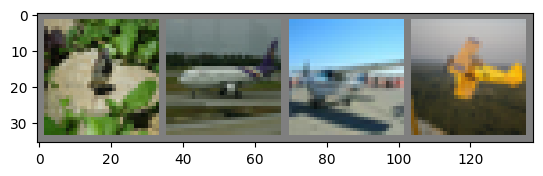

bird  plane plane plane


In [80]:
# 显示图片
# torchvision.utils.make_grid() 将一个 batch 的图像拼成一个，返回一个 (C, H, W) 的 tensor
# 然后调用自定义的 imshow，用 plt 画出来
imshow(torchvision.utils.make_grid(images))

# 显示 labels
# .join() 将一个字符串列表连接成一个字符串，其中列表中的每个元素之间用指定的分隔符（这里是空格）隔开
# :5s 表示将该元素格式化为宽度为5的字符串
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

### 2.2 定义CNN的结构

复制之前第1部分中的神经网络，并对其进行修改，以获取 3 通道图像（而不是定义的 1 通道图像）。

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [83]:
class Net(nn.Module):
    """定义 3 通道的 LeNet"""
    def __init__(self):
        super(Net, self).__init__()  # 调用父类的 __init__() 方法
        # 卷积层 conv
        # conv1: 输入大小为32*32，输出大小为28*28，输入通道为1，输出为6，卷积核大小为5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # conv2: 输入大小为14*14，输出大小为10*10，输入通道为6，输出为16，卷积核大小为5
        self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        """ ------------- end -------------- """
        # 全连接层 fc
        # fc1: 输入神经元数目 16 * 5 * 5，输出神经元数目 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        """ -------- Your code here -------- """
        # fc2: 输入神经元数目 120，输出神经元数目 84
        self.fc2 = nn.Linear(120, 84)
        # fc3: 输入神经元数目 84，输出神经元数目 10
        self.fc3 = nn.Linear(84, 10)
        """ ------------- end -------------- """

    def forward(self, x):
        # conv1 - relu - maxpool(2x)
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        # conv2 - relu -maxpool(2x)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        """ ------------- end -------------- """
        # flatten
        x = torch.flatten(x,start_dim=1, end_dim = -1)  # 把除了 batch 维度(dim=0)的数据全部 flatten
        # fc1 - relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [84]:
# 实例化
net = Net()

### 2.3 定义损失函数和优化器

使用分类交叉熵损失和带动量的 SGD。

In [85]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)

### 2.4 训练网络

只需在数据迭代器上循环，并将输入输入到网络中，然后进行优化。

In [86]:
# 测试，对 trainloader 进行迭代，返回值类别也是 list
# 里面装着 2 个 tensor，分别是这一个 batch 的 images 和 labels
for i in trainloader:
    print(type(i))
    print(len(i))
    break

<class 'list'>
2


In [87]:
for epoch in range(2):  # 设置在训练集上 loop 的总轮数
    running_loss = 0.0
    # enumerate() 用于为可迭代对象（如列表、元组、字符串等）提供索引。
    # 第一个参数为要迭代的对象，第二个为起始索引(默认0)
    for i, data in enumerate(trainloader, start=0):
        # 枚举获取训练 inputs。data 的形式为 list [inputs, labels]
        inputs, labels = data

        # 清除参数梯度
        optimizer.zero_grad()
        # forward
        outputs = net(inputs)
        # loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameters
        optimizer.step()

        # 打印 status，便于观察训练状态
        running_loss += loss.item()  # 使用 nn.CrossEntropyLoss() 定义的准则，返回值为一个 1 维 tensor，即 torch.tensor([loss])，需要用 .item() 获取具体数值
        if i % 2000 == 1999:  # 每训练 2000 个 batch 打印一次
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000 :.3f}")  # 打印 [epoch, iter] 以及上 2000 次训练的平均 loss
            running_loss = 0.0

print("Finish Training")

[1,  2000] loss: 2.249
[1,  4000] loss: 1.858
[1,  6000] loss: 1.658
[1,  8000] loss: 1.565
[1, 10000] loss: 1.503
[1, 12000] loss: 1.447
[2,  2000] loss: 1.377
[2,  4000] loss: 1.333
[2,  6000] loss: 1.334
[2,  8000] loss: 1.283
[2, 10000] loss: 1.256
[2, 12000] loss: 1.250
Finish Training


保存训练好的模型：

In [88]:
PATH = "./weights/cifar_net.pth"
torch.save(net.state_dict(), PATH)

In [89]:
# net.state_dict() 中以 OrderedDict 字典形式存储模型参数
# 例如，可以索引其中的具体 tensor
net.state_dict()['conv1.weight']

tensor([[[[-1.6891e-01, -2.2227e-01, -6.6516e-02, -1.1954e-01, -1.0225e-01],
          [-1.0792e-01, -2.4442e-03, -7.6762e-02,  1.4488e-02, -5.2769e-02],
          [-1.3405e-01,  1.2971e-01,  1.9437e-01,  1.0876e-01, -6.1907e-02],
          [ 7.4051e-02,  3.0006e-01,  1.8518e-01,  9.6937e-02,  1.1893e-01],
          [ 2.0160e-01,  2.6497e-01,  2.4161e-01,  2.3722e-01,  1.9191e-01]],

         [[-4.9514e-02, -7.8204e-02, -4.7417e-02,  9.4664e-02,  3.6987e-02],
          [-5.5425e-02,  3.1307e-02,  1.0434e-01,  6.7251e-02, -7.9187e-02],
          [-5.3898e-02,  1.3479e-02,  1.0999e-01,  5.1274e-02,  3.4145e-02],
          [-9.1312e-02,  8.1669e-02,  6.9080e-02, -1.3392e-02, -1.7529e-02],
          [-5.4114e-03,  2.3324e-02,  3.8269e-02, -1.4138e-01, -1.5704e-01]],

         [[ 1.0743e-02,  2.2735e-01,  2.0610e-01,  1.8951e-01,  1.0157e-01],
          [-1.8156e-02,  7.2770e-02,  2.5025e-01,  1.5540e-01,  7.9515e-02],
          [-4.1198e-02,  1.9861e-01,  1.3569e-01,  1.0535e-01, -2.0530e-

#### 2.5 测试网络训练效果

我们在训练数据集上对网络进行了 2 次训练。但我们需要检查网络是否学到了东西。

我们将通过预测神经网络输出的类别标签来检查这一点，并将其与 ground truth 进行核对。如果预测正确，我们就将样本添加到正确预测列表中。

首先，让我们显示测试集中的一幅图像，熟悉一下。

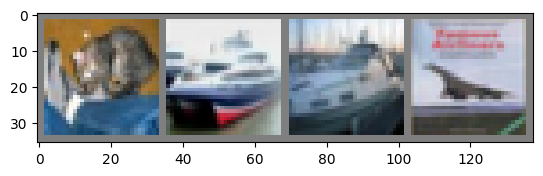

GroundTruth: cat   ship  ship  plane


In [94]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 打印图像
imshow(torchvision.utils.make_grid(images))
print("GroundTruth:", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

接下来，重新加载已保存的模型：

In [95]:
net = Net()
net.load_state_dict(torch.load(PATH))

C:\Users\65197\AppData\Local\Temp\ipykernel_3472\3657762129.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

现在让我们看看神经网络认为上面这些例子是什么：

In [96]:
outputs = net(images)
outputs

tensor([[-0.7054, -2.5185,  0.3807,  3.1581,  1.3970,  2.4563,  0.5369, -0.9461,
         -1.3609, -2.1283],
        [ 4.9085,  7.4135, -1.3823, -3.5312, -2.8124, -3.1874, -4.0331, -4.8685,
          6.5649,  3.3223],
        [ 2.3018,  2.9113, -0.8363, -1.2821, -2.2285, -1.7152, -2.3546, -2.4124,
          2.8247,  2.6798],
        [ 3.5437, -0.1411,  0.4979, -0.8310, -0.2103, -2.0533, -1.8349, -1.5262,
          2.7941,  0.2497]], grad_fn=<AddmmBackward0>)

输出是 10 个类别的 energies。某个类别的 energies 越高，网络就越认为图像属于该类别。因此，我们来获取最高 energies 的 index：

In [97]:
# torch.max() 接收 tensor 和 dim，求在 dim 维上的最大值
# dim=1 表示在 1 维上求最大值，即最里面的数据维，一行 10 个里面求最大
# 返回两个 tensor，分别为最大值和索引
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  cat   car   car   plane


让我们看看该网络在整个数据集上的表现。

In [98]:
correct = 0
total = 0
# 由于并不是在训练，因此不用计算 outputs 的梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # forward
        outputs = net(images)
        # 取最高的 energy 的 index 作为预测值
        _, predicted = torch.max(outputs.data, 1)
        # labels 的 size 是 (batchsize)
        total += labels.size(0)
        # 获取预测正确的 bool tensor，求和后取出 tensor 中的数字
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total}%")

Accuracy of the network on the 10000 test images: 56%


该结果比纯随机性要好得多。纯随机的准确率是 10%（从 10 个类别中随机挑选一个类别）。

观察哪些类别表现良好，哪些类别表现不佳：

In [99]:
# 准备对每一个 class 进行预测和计数
# 此处生成了两个 dict, key 为 classname，value 均为 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 不计算梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 统计每个 class 中正确预测的情况
        # zip函数可以将两个或更多的序列（列表、元组等）组合成一个序列，进行取用和迭代
        # labels, predictions 里面存了 1 个 batch 的数据，将他们迭代出来
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                # correct_pred 字典中对应的 class 的 label +1
                correct_pred[classes[label]] += 1
            # 总数字典中对应的 class 的 label +1
            total_pred[classes[label]] += 1

# 打印每个 class 的 accuracy
# correct_pred.items() 表示从字典 correct_pred 取出 key 和 value，赋给 classname, correct_count
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f}%")

Accuracy for class: plane is 71.0%
Accuracy for class: car   is 66.9%
Accuracy for class: bird  is 29.6%
Accuracy for class: cat   is 35.0%
Accuracy for class: deer  is 44.6%
Accuracy for class: dog   is 58.7%
Accuracy for class: frog  is 60.5%
Accuracy for class: horse is 63.0%
Accuracy for class: ship  is 60.5%
Accuracy for class: truck is 72.9%


In [ ]:
# 神经网络原因或者是数据原因 多方面原因造成的 